In [1]:
from tqdm import tqdm as tqdm
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import DataStructs
from Bio.SeqUtils.ProtParam import ProteinAnalysis
import numpy as np
from sklearn.preprocessing import normalize
from itertools import product
import math

negative_ratio='1'

def get_fingerprint(smiles, r=3, nBits=1024):
    compound = Chem.MolFromSmiles(smiles.strip())
    fingerprint = AllChem.GetMorganFingerprintAsBitVect(compound, r, nBits=nBits)
    m = np.zeros((0, ), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(fingerprint,m)
    return m

def sequence_to_kmer(protein_seq, k):
    groups={'A':'1','V':'1','G':'1','I':'2','L':'2','F':'2','P':'2','Y':'3',
            'M':'3','T':'3','S':'3','H':'4','N':'4','Q':'4','W':'4',
            'R':'5','K':'5','D':'6','E':'6','C':'7'}
    crossproduct=[''.join (i) for i in product("1234567",repeat=k)]
    for i in range(0, len(crossproduct)): crossproduct[i]=int(crossproduct[i])
    ind=[]
    for i in range(0, len(crossproduct)): ind.append(i)
    combinations=dict(zip(crossproduct, ind))
    
    V=np.zeros(int((math.pow(7,k))))
    try:
        for j in range(0, len(protein_seq)-k+1):
            kmer=protein_seq[j:j+k]
            c=''
            for l in range(0, k):
                c+=groups[kmer[l]]
                V[combinations[int(c)]] += 1
    except:
        count={'1':0,'2':0,'3':0, '4':0, '5':0,'6':0,'7':0}
        for q in range(0,len(protein_seq)):
            if protein_seq[q]=='A' or protein_seq[q]=='V' or protein_seq[q]=='G':
                count['1']+=1
            if protein_seq[q]=='I' or protein_seq[q]=='L'or protein_seq[q]=='F' or protein_seq[q]=='P':
                count['2']+=1
            if protein_seq[q]=='Y' or protein_seq[q]=='M'or protein_seq[q]=='T' or protein_seq[q]=='S':
                count['3']+=1
            if protein_seq[q]=='H' or protein_seq[q]=='N'or protein_seq[q]=='Q' or protein_seq[q]=='W':
                count['4']+=1
            if protein_seq[q]=='R' or protein_seq[q]=='K':
                count['5']+=1
            if protein_seq[q]=='D' or protein_seq[q]=='E':
                count['6']+=1
            if protein_seq[q]=='C':
                count['7']+=1
        
        value=list(count.values())
        key=list(count.keys())
        maximum_occurence=0
        index=0
        for t in range(0, len(value)):
            if maximum_occurence < value[t]:
                maximum_occurence = value[t]
                index=t
        maximum_occurence = key[index] # group number of maximum occuring group
        for j in range(0, len(protein_seq)-k+1):
            kmer=protein_seq[j:j+k]
            c=''
            for l in range(0, k):
                if kmer[l] not in groups:
                    c += maximum_occurence
                else:
                    c+=groups[kmer[l]]
            V[combinations[int(c)]] += 1
            
        V = V/(len(protein_seq)-1)
        return np.array(V)
    
def get_protein_features(protein_sequence):
    aa=['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
    f = []
    protein_info = ProteinAnalysis(str(protein_sequence))
    protein_info.molecular_weight()
    amino_acid_percent = protein_info.get_amino_acids_percent()
    dp = []
    for a in aa:
        dp.append(amino_acid_percent[a])
    dp=np.array(dp)
    dp=normalize(np.atleast_2d(dp), norm='l2', copy=True, axis=1, return_norm=False)
    f.extend(dp[0])
    twomer=np.array(sequence_to_kmer(str(protein_sequence), 2))
    twomer=normalize(np.atleast_2d(twomer), norm='l2', copy=True, axis=1,return_norm=False)
    f.extend(twomer[0])
    threemer=np.array(sequence_to_kmer(str(protein_sequence), 3))
    threemer=normalize(np.atleast_2d(threemer), norm='l2', copy=True, axis=1,return_norm=False)
    f.extend(threemer[0])
    return np.array(f)
    

def process_data_file(text_file):
    with open(text_file) as f:
        lines = f.readlines()

    compounds = []; proteins = []; Y=[]
    compound_seq = []; protein_seq = [] # may not be necessary
    for line in tqdm(lines):
        compound, protein, label = line.split() # compounds are in SMILES format
        try:
            morgan_fingerprint = get_fingerprint(compound)
            protein_sequence = get_protein_features(protein)
        except Exception as e:
            print(e)
            continue
        compounds.append(morgan_fingerprint)
        proteins.append(protein_sequence)
        compound_seq.append(compound) # smiles format of compounds
        protein_seq.append(protein) # protein sequences
        Y.append(2*float(label)-1)

    # convert lists to numpy arrays
    Y = np.array(Y)
    compounds = np.array(compounds)
    proteins = np.array(proteins)
    
    return Y, compounds, proteins, protein_seq, compound_seq

Y, compounds, proteins, protein_seq, compound_seq = process_data_file('NR-HCPI/pos2negtiveRatio1_Random.txt')


100%|█████████████████████████████████████████████████████████████████████████████| 5266/5266 [00:25<00:00, 202.55it/s]


In [2]:
print("label shape: ", Y.shape)
print("compound shape", compounds.shape)
print("protein shape: ", proteins.shape)

label shape:  (5266,)
compound shape (5266, 1024)
protein shape:  (5266, 412)


In [3]:
def create_dataset_and_labels(proteins, compounds, Y):
    proteins_compounds_combined = np.column_stack((proteins, compounds))
    print("shape of X: ", proteins_compounds_combined.shape)

    y_classification = []

    for label in Y:
        if label == 1.0:
            y_classification.append(1)
        else:
            y_classification.append(0)

    y_classification = np.array(y_classification)
    print(y_classification)
    
    return y_classification, proteins_compounds_combined

y_classification, proteins_compounds_combined = create_dataset_and_labels(proteins, compounds, Y)

shape of X:  (5266, 1436)
[1 1 1 ... 0 0 0]


In [4]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
import xgboost as xgb

skf = StratifiedKFold(n_splits=5, shuffle=True)
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss")

def train_xgb_stratifiedkfold(model, dataset, labels):
    accuracy_scores = []
    auc_roc_scores = []
    pr_curve_scores = []
    fold_no = 1
    for train_index, test_index in skf.split(dataset, labels):
        X_train, X_test = dataset[train_index], dataset[test_index]
        y_train, y_test = labels[train_index], labels[test_index]
        model.fit(X_train, y_train)
        prediction_probabilities = model.predict_proba(X_test)
        prediction_probabilities = prediction_probabilities[:,1]
        predictions = model.predict(X_test)
        ACCURACY = accuracy_score(y_test, predictions)
        AUC_ROC = roc_auc_score(y_test, prediction_probabilities)
        PR_SCORE = average_precision_score(y_test, prediction_probabilities)
        accuracy_scores.append(ACCURACY)
        auc_roc_scores.append(AUC_ROC)
        pr_curve_scores.append(PR_SCORE)
        print("Fold ", fold_no, " results: ", "accuracy ", ACCURACY, " auc_roc: ", AUC_ROC, " precision_recall: ", PR_SCORE)
        fold_no += 1
    
    return accuracy_scores, auc_roc_scores, pr_curve_scores
    
accuracy_scores, auc_roc_scores, pr_curve_scores = train_xgb_stratifiedkfold(model, proteins_compounds_combined, y_classification)
print("Mean accuracy: ", np.mean(accuracy_scores))
print("Mean auc roc: ", np.mean(auc_roc_scores))
print("Mean precision recall: ", np.mean(pr_curve_scores))

C:\Users\antre\anaconda3\envs\myenv\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Fold  1  results:  accuracy  0.8225806451612904  auc_roc:  0.9032798159356782  precision_recall:  0.912626515778937
Fold  2  results:  accuracy  0.8167141500474834  auc_roc:  0.8991782166073838  precision_recall:  0.9042024490613936
Fold  3  results:  accuracy  0.805318138651472  auc_roc:  0.8848673530494008  precision_recall:  0.8922766220669185
Fold  4  results:  accuracy  0.8309591642924976  auc_roc:  0.9015771891977691  precision_recall:  0.9080158929675136
Fold  5  results:  accuracy  0.8157644824311491  auc_roc:  0.887511634115194  precision_recall:  0.8912325714419433
Mean accuracy:  0.8182673161167784
Mean auc roc:  0.8952828417810851
Mean precision recall:  0.9016708102633413


In [5]:
# from sklearn.metrics.pairwise import rbf_kernel as kernel
# from sklearn.preprocessing import StandardScaler

# def generate_negative_examples(protein_seq, compound_seq, threshold):
#     protein_set = list(set(protein_seq))
#     protein_indices = list(range(len(protein_set)))
#     protein_dict = dict(zip(protein_set, protein_indices))
#     compound_set = list(set(compound_seq))
#     compound_indices = list(range(len(compound_set)))
#     compound_dict = dict(zip(compound_set, compound_indices))
#     protein_compound_pairs = np.array([(protein_dict[p], compound_dict[c]) for (p,c) in zip(protein_seq, compound_seq)])
#     pos, negs = protein_compound_pairs[Y==1,:], protein_compound_pairs[Y!=1,:]
    
#     # keep only positive indices
#     protein_indices, compound_indices = list(set(pos[:,0])), list(set(pos[:,1]))
    
#     # remove redundant positive and negative examples
#     pos, negs = list(set(map(tuple, pos.tolist()))), list(set(map(tuple, negs.tolist())))
    
#     positive_protein_sequences = np.array([s[0] for s in pos])
#     positive_protein_features = np.array([get_protein_features(protein_set[s]) for s in positive_protein_sequences])
    
#     positive_compound_sequences = np.array([s[1] for s in pos])
#     positive_compound_features = np.array([get_fingerprint(compound_set[s]) for s in positive_compound_sequences])
    
#     positive_proteins_scaler = StandardScaler().fit(positive_protein_features)
#     positive_compounds_scaler = StandardScaler().fit(positive_compound_features)
#     positive_proteins_scaled = positive_proteins_scaler.transform(positive_protein_features)
#     positive_compounds_scaled = positive_compounds_scaler.transform(positive_compound_features)
    
#     positive_proteins_kernel = kernel(positive_proteins_scaled)
#     positive_compounds_kernel = kernel(positive_compounds_scaled)
#     protein_kernel_dict = dict(zip(positive_protein_sequences, positive_proteins_kernel))
#     compound_kernel_dict = dict(zip(positive_compound_sequences, positive_compounds_kernel))
    
#     negative_examples = {}
#     while len(negative_examples) < 100:
#         pair = (random.choice(protein_indices), random.choice(compound_indices))
#         protein_index = np.argmax(protein_kernel_dict[pair[0]])
#         new_protein_kernel=np.delete(positive_proteins_kernel[protein_index], protein_index)
#         compound_index = np.argmax(compound_kernel_dict[pair[1]])
#         new_compound_kernel = np.delete(positive_compounds_kernel[compound_index], compound_index)
#         alpha=np.max(new_protein_kernel)*np.max(new_compound_kernel)
#         if pair not in pos and pair not in negs and alpha<threshold:
#             negative_examples[pair[0]] = pair[1] # protein -> compound
#     return negative_examples


# generated_negatives = generate_negative_examples(protein_seq, compound_seq, 0.5)

In [6]:
# alpha = 0.1
Y_01, compounds_01, proteins_01, protein_seq_01, compound_seq_01 = process_data_file('NR-HCPI/pos2negtiveRatio1_Alpha_threshold_0.1.txt')
y_classification_01, proteins_compounds_combined_01 = create_dataset_and_labels(proteins_01, compounds_01, Y_01)
accuracy_scores_0_1, auc_roc_scores_0_1, pr_curve_scores_0_1 = train_xgb_stratifiedkfold(model, proteins_compounds_combined_01, y_classification_01)

100%|█████████████████████████████████████████████████████████████████████████████| 5266/5266 [00:25<00:00, 209.42it/s]


shape of X:  (5266, 1436)
[1 1 1 ... 0 0 0]
Fold  1  results:  accuracy  0.9487666034155597  auc_roc:  0.9867280694489952  precision_recall:  0.9900538031084101
Fold  2  results:  accuracy  0.9420702754036088  auc_roc:  0.9844553791098188  precision_recall:  0.9866107333238066
Fold  3  results:  accuracy  0.9449192782526116  auc_roc:  0.9848197343453511  precision_recall:  0.9868661274071168
Fold  4  results:  accuracy  0.9439696106362773  auc_roc:  0.9823630421136932  precision_recall:  0.9853915287464005
Fold  5  results:  accuracy  0.9354226020892688  auc_roc:  0.9774244053073209  precision_recall:  0.9829011725218051


In [7]:
# alpha=0.2
Y_02, compounds_02, proteins_02, protein_seq_02, compound_seq_02 = process_data_file('NR-HCPI/pos2negtiveRatio1_Alpha_threshold_0.2.txt')
y_classification_02, proteins_compounds_combined_02 = create_dataset_and_labels(proteins_02, compounds, Y_02)
accuracy_scores_0_2, auc_roc_scores_0_2, pr_curve_scores_0_2 = train_xgb_stratifiedkfold(model, proteins_compounds_combined_02, y_classification_02)

100%|█████████████████████████████████████████████████████████████████████████████| 5266/5266 [00:23<00:00, 220.49it/s]


shape of X:  (5266, 1436)
[1 1 1 ... 0 0 0]
Fold  1  results:  accuracy  0.7760910815939279  auc_roc:  0.8389365172524296  precision_recall:  0.8742089551365961
Fold  2  results:  accuracy  0.7587844254510921  auc_roc:  0.8240200287155215  precision_recall:  0.850058782759768
Fold  3  results:  accuracy  0.7578347578347578  auc_roc:  0.8246405148592002  precision_recall:  0.850891871784867
Fold  4  results:  accuracy  0.7521367521367521  auc_roc:  0.8047452760081095  precision_recall:  0.8441590239810814
Fold  5  results:  accuracy  0.7388414055080722  auc_roc:  0.8044350329362702  precision_recall:  0.8453364808885262


In [8]:
# alpha=0.4
Y_04, compounds_04, proteins_04, protein_seq_04, compound_seq_04 = process_data_file('NR-HCPI/pos2negtiveRatio1_Alpha_threshold_0.4.txt')
y_classification_04, proteins_compounds_combined_04 = create_dataset_and_labels(proteins_04, compounds_04, Y_04)
accuracy_scores_0_4, auc_roc_scores_0_4, pr_curve_scores_0_4 = train_xgb_stratifiedkfold(model, proteins_compounds_combined_04, y_classification_04)

100%|█████████████████████████████████████████████████████████████████████████████| 5266/5266 [00:22<00:00, 230.16it/s]


shape of X:  (5266, 1436)
[1 1 1 ... 0 0 0]
Fold  1  results:  accuracy  0.8776091081593927  auc_roc:  0.9394229626722452  precision_recall:  0.9460678985415611
Fold  2  results:  accuracy  0.8727445394112061  auc_roc:  0.9359131607997055  precision_recall:  0.9357482798171627
Fold  3  results:  accuracy  0.8575498575498576  auc_roc:  0.9232509144955664  precision_recall:  0.9263584293350278
Fold  4  results:  accuracy  0.8774928774928775  auc_roc:  0.9538747916681698  precision_recall:  0.9577529492702906
Fold  5  results:  accuracy  0.8660968660968661  auc_roc:  0.937839553827173  precision_recall:  0.9462411373752928


In [9]:
# alpha=0.6
Y_06, compounds_06, proteins_06, protein_seq_06, compound_seq_06 = process_data_file('NR-HCPI/pos2negtiveRatio1_Alpha_threshold_0.6.txt')
y_classification_06, proteins_compounds_combined_06 = create_dataset_and_labels(proteins_06, compounds_06, Y_06)
accuracy_scores_0_6, auc_roc_scores_0_6, pr_curve_scores_0_6 = train_xgb_stratifiedkfold(model, proteins_compounds_combined_06, y_classification_06)

100%|█████████████████████████████████████████████████████████████████████████████| 5266/5266 [00:22<00:00, 229.02it/s]


shape of X:  (5266, 1436)
[1 1 1 ... 0 0 0]
Fold  1  results:  accuracy  0.8662239089184061  auc_roc:  0.9250240342204092  precision_recall:  0.9310271522556204
Fold  2  results:  accuracy  0.8442545109211775  auc_roc:  0.9235936248656215  precision_recall:  0.9285009762231957
Fold  3  results:  accuracy  0.8566001899335233  auc_roc:  0.9283446728378583  precision_recall:  0.9393700562973732
Fold  4  results:  accuracy  0.8366571699905033  auc_roc:  0.9092755463524795  precision_recall:  0.9148379340910098
Fold  5  results:  accuracy  0.8575498575498576  auc_roc:  0.9333807115388779  precision_recall:  0.9383133748793524


In [10]:
# alpha=0.8
Y_08, compounds_08, proteins_08, protein_seq_08, compound_seq_08 = process_data_file('NR-HCPI/pos2negtiveRatio1_Alpha_threshold_0.8.txt')
y_classification_08, proteins_compounds_combined_08 = create_dataset_and_labels(proteins_08, compounds_08, Y_08)
accuracy_scores_0_8, auc_roc_scores_0_8, pr_curve_scores_0_8 = train_xgb_stratifiedkfold(model, proteins_compounds_combined_08, y_classification_08)

100%|█████████████████████████████████████████████████████████████████████████████| 5266/5266 [00:22<00:00, 229.26it/s]


shape of X:  (5266, 1436)
[1 1 1 ... 0 0 0]
Fold  1  results:  accuracy  0.8671726755218216  auc_roc:  0.9263652697413667  precision_recall:  0.9268303058582393
Fold  2  results:  accuracy  0.8452041785375118  auc_roc:  0.9229298489909885  precision_recall:  0.9316183275009837
Fold  3  results:  accuracy  0.8584995251661919  auc_roc:  0.9339326556085454  precision_recall:  0.9405536833054963
Fold  4  results:  accuracy  0.8480531813865148  auc_roc:  0.9150835852555178  precision_recall:  0.9260879005745618
Fold  5  results:  accuracy  0.8404558404558404  auc_roc:  0.8990880296678958  precision_recall:  0.9051246688842297


In [11]:
# alpha=1.0
Y_10, compounds_10, proteins_10, protein_seq_10, compound_seq_10 = process_data_file('NR-HCPI/pos2negtiveRatio1_Alpha_threshold_1.0.txt')
y_classification_10, proteins_compounds_combined_10 = create_dataset_and_labels(proteins_10, compounds_10, Y_10)
accuracy_scores_1_0, auc_roc_scores_1_0, pr_curve_scores_1_0 = train_xgb_stratifiedkfold(model, proteins_compounds_combined_10, y_classification_10)

100%|█████████████████████████████████████████████████████████████████████████████| 5266/5266 [00:23<00:00, 227.14it/s]


shape of X:  (5266, 1436)
[1 1 1 ... 0 0 0]
Fold  1  results:  accuracy  0.816888045540797  auc_roc:  0.8967014607765122  precision_recall:  0.9036205203603007
Fold  2  results:  accuracy  0.842355175688509  auc_roc:  0.9044884236044473  precision_recall:  0.9156212758970309
Fold  3  results:  accuracy  0.8309591642924976  auc_roc:  0.8993838428294169  precision_recall:  0.9063859494978276
Fold  4  results:  accuracy  0.8366571699905033  auc_roc:  0.9095424996933644  precision_recall:  0.9182532554491832
Fold  5  results:  accuracy  0.8195631528964862  auc_roc:  0.8915700463921618  precision_recall:  0.8942558304316738


[0.9831581260650358, 0.8193554739543062, 0.9380602766925719, 0.9239237179630493, 0.9194798778528629, 0.9003372546591806]


Text(0, 0.5, 'auc roc score')

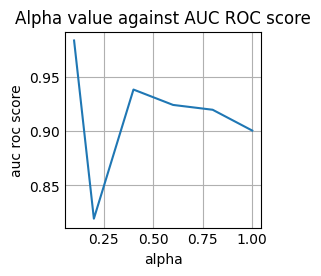

In [12]:
import matplotlib.pyplot as plt
plt.style.use('_mpl-gallery')

auc_roc_01 = np.mean(auc_roc_scores_0_1)
auc_roc_02 = np.mean(auc_roc_scores_0_2)
auc_roc_04 = np.mean(auc_roc_scores_0_4)
auc_roc_06 = np.mean(auc_roc_scores_0_6)
auc_roc_08 = np.mean(auc_roc_scores_0_8)
auc_roc_10 = np.mean(auc_roc_scores_1_0)

auc_rocs = [auc_roc_01, auc_roc_02, auc_roc_04, auc_roc_06, auc_roc_08, auc_roc_10]
alphas = [0.1, 0.2, 0.4, 0.6, 0.8, 1.0]
print(auc_rocs)

plt.plot(alphas,auc_rocs)
plt.title('Alpha value against AUC ROC score')
plt.xlabel('alpha')
plt.ylabel('auc roc score')
# plt.show()

[0.9863646730215077, 0.8529310229101676, 0.942433738867867, 0.9304098987493102, 0.9260429772247022, 0.9076273663272032]


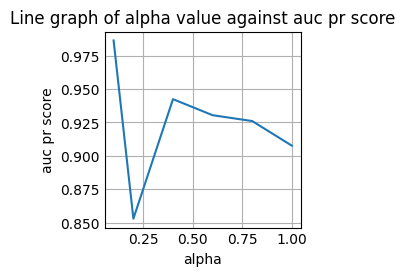

In [13]:
auc_pr_01 = np.mean(pr_curve_scores_0_1)
auc_pr_02 = np.mean(pr_curve_scores_0_2)
auc_pr_04 = np.mean(pr_curve_scores_0_4)
auc_pr_06 = np.mean(pr_curve_scores_0_6)
auc_pr_08 = np.mean(pr_curve_scores_0_8)
auc_pr_10 = np.mean(pr_curve_scores_1_0)

auc_prs = [auc_pr_01, auc_pr_02, auc_pr_04, auc_pr_06, auc_pr_08, auc_pr_10]
alphas = [0.1, 0.2, 0.4, 0.6, 0.8, 1.0]
print(auc_prs)

plt.plot(alphas,auc_prs)
plt.title('Line graph of alpha value against auc pr score')
plt.xlabel('alpha')
plt.ylabel('auc pr score')
plt.show()